# <a id='toc1_'></a>[Model Evaluation](#toc0_)

This notebook contains the code to evaluate the models on the test set.

**Table of contents**<a id='toc0_'></a>    
- [Model Evaluation](#toc1_)    
- [Import libraries](#toc2_)    
- [Import data](#toc3_)    
- [Prepare data for training](#toc4_)    
  - [Neural network data](#toc4_1_)    
  - [Linear model data](#toc4_2_)    
- [Train Neural Network](#toc5_)    
  - [Graph the model](#toc5_1_)    
- [Train linear models](#toc6_)    
  - [OLS](#toc6_1_)    
  - [LASSO](#toc6_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Import libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.compose import ColumnTransformer
import shap
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import math
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning

from libs.models import *
from libs.functions import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

%load_ext autoreload
%autoreload 2

# <a id='toc3_'></a>[Import data](#toc0_)

In [2]:
# read data
df = pd.read_csv('data/data.csv')

# <a id='toc4_'></a>[Prepare data for training](#toc0_)

## <a id='toc4_1_'></a>[Neural network data](#toc0_)
Including a validation set

In [3]:
# identify dummy vs. numeric columns
feature_cols = [col for col in df.columns if col not in ['timestamp', 'ticker', 'target']]
cat_cols = [c for c in feature_cols if c.startswith('NACE_') or c.startswith('month_')] + ['divi','divo','sin']
numeric_cols = [c for c in feature_cols if c not in cat_cols]
feature_cols = numeric_cols + cat_cols # reorder columns to have numeric first

df_norm = df.copy(deep=True)
# df_norm = df_norm.dropna(subset=feature_cols)  # should not drop any rows
df_norm['timestamp'] = pd.to_datetime(df_norm['timestamp'])

# drop data from 2025
df_norm = df_norm[df_norm['timestamp'] < '2025-01-01']

# prepare expanding window splits
periods = {
    '20' : '2020-01-01', 
    '21' : '2021-01-01', 
    '22' : '2022-01-01',  
    '23': '2023-01-01'
}

# Prepare containers
X_train, X_val, X_test = {}, {}, {}
y_train, y_val, y_test = {}, {}, {}
preprocessors = {}

y_values = df_norm['target'].values.astype('float32')

for y, period in periods.items():
    period = pd.to_datetime(period)

    # split masks
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract raw feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols].copy()
    X_va_df = df_norm.loc[va_mask, feature_cols].copy()
    X_te_df = df_norm.loc[te_mask, feature_cols].copy()
    y_tr    = y_values[tr_mask]
    y_va    = y_values[va_mask]
    y_te    = y_values[te_mask]

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, val, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_va_df[numeric_cols] = X_va_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    # X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)

    # now fit scaler on numeric only
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough',  cat_cols)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors[y] = preprocessor

    # transform all splits
    X_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    X_val[y]   = preprocessor.transform(X_va_df).astype('float32')
    X_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # store targets as before
    y_train[y] = y_tr.reshape(-1, 1)
    y_val[y]   = y_va.reshape(-1, 1)
    y_test[y]  = y_te.reshape(-1, 1)


## <a id='toc4_2_'></a>[Linear model data](#toc0_)
Excluding the validation set

In [4]:

Xlin_train, Xlin_test = {}, {}
ylin_train, ylin_test = {}, {}
preprocessors_lin = {}

for y, period in periods.items():
    period = pd.to_datetime(period)
    tr_mask = df_norm['timestamp']- pd.DateOffset(years=1) < period
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols]
    X_te_df = df_norm.loc[te_mask, feature_cols]
    y_tr = y_values[tr_mask]
    y_te = y_values[te_mask]

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)

    # fit scaler only on training set
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough', cat_cols)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors_lin[y] = preprocessor

    # ttransform splits
    Xlin_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    Xlin_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # targets
    ylin_train[y] = y_tr
    ylin_test[y]  = y_te

# <a id='toc5_'></a>[Train Neural Network](#toc0_)

In [5]:
# moving to metal or CUDA GPU if available
device = torch.device(("cuda" if torch.cuda.is_available() 
                       else "mps" if torch.backends.mps.is_available() 
                       else "cpu"))
print("Using device:", device)

# general hyperparameters
hidden_depth = 4 # only hidden, excluding in- and output layers
hidden_width = [32,16,8,4] # int for all being equal width; list for different widths
learning_rate = 1e-4
activation_fun = nn.ReLU # # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU

# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 1e-3 # 1e-3 # currently 0 
weight_decay = 1e-3 # l2 regularization
dropout = 0.2

# general parmeters
patience = 250
print_freq = 250
epochs = 250
batch_size = 4096 # 8192 # 16384 # 2^1X adjust to your memory


Using device: mps


In [ ]:
best_models = {}
history = {}
models = {}
preds = {}

for y, period in periods.items():
    np.random.seed(42)
    torch.manual_seed(42)
    print(f"Training model for year '{y}...")
    input_dim = X_train[y].shape[1]
    models[y] = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
    optimizer = torch.optim.AdamW(models[y].parameters(), weight_decay=weight_decay, lr=learning_rate)
    train = MLPdataset(X_train[y], y_train[y])
    val = MLPdataset(X_val[y], y_val[y])
    best_models[y], history[y] = train_mlp(train,          
                                                val,
                                                models[y],
                                                criterion,
                                                epochs,
                                                patience,
                                                print_freq,
                                                device,
                                                optimizer,
                                                lambda_l1=lambda_l1,
                                                batch_size=batch_size,
                                                shuffle_train=True,
                                                shuffle_val=False,
                                                save_path=f'models/mlp_y{y}_l1{lambda_l1}_l2{weight_decay}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}.pth'
                                                )
    preds[y] = predict_mlp(best_models[y],
                              X_test[y],
                              y_test[y],
                              batch_size=batch_size,
                              device=device)

Training model for year '20...


## <a id='toc5_1_'></a>[Graph the model](#toc0_)

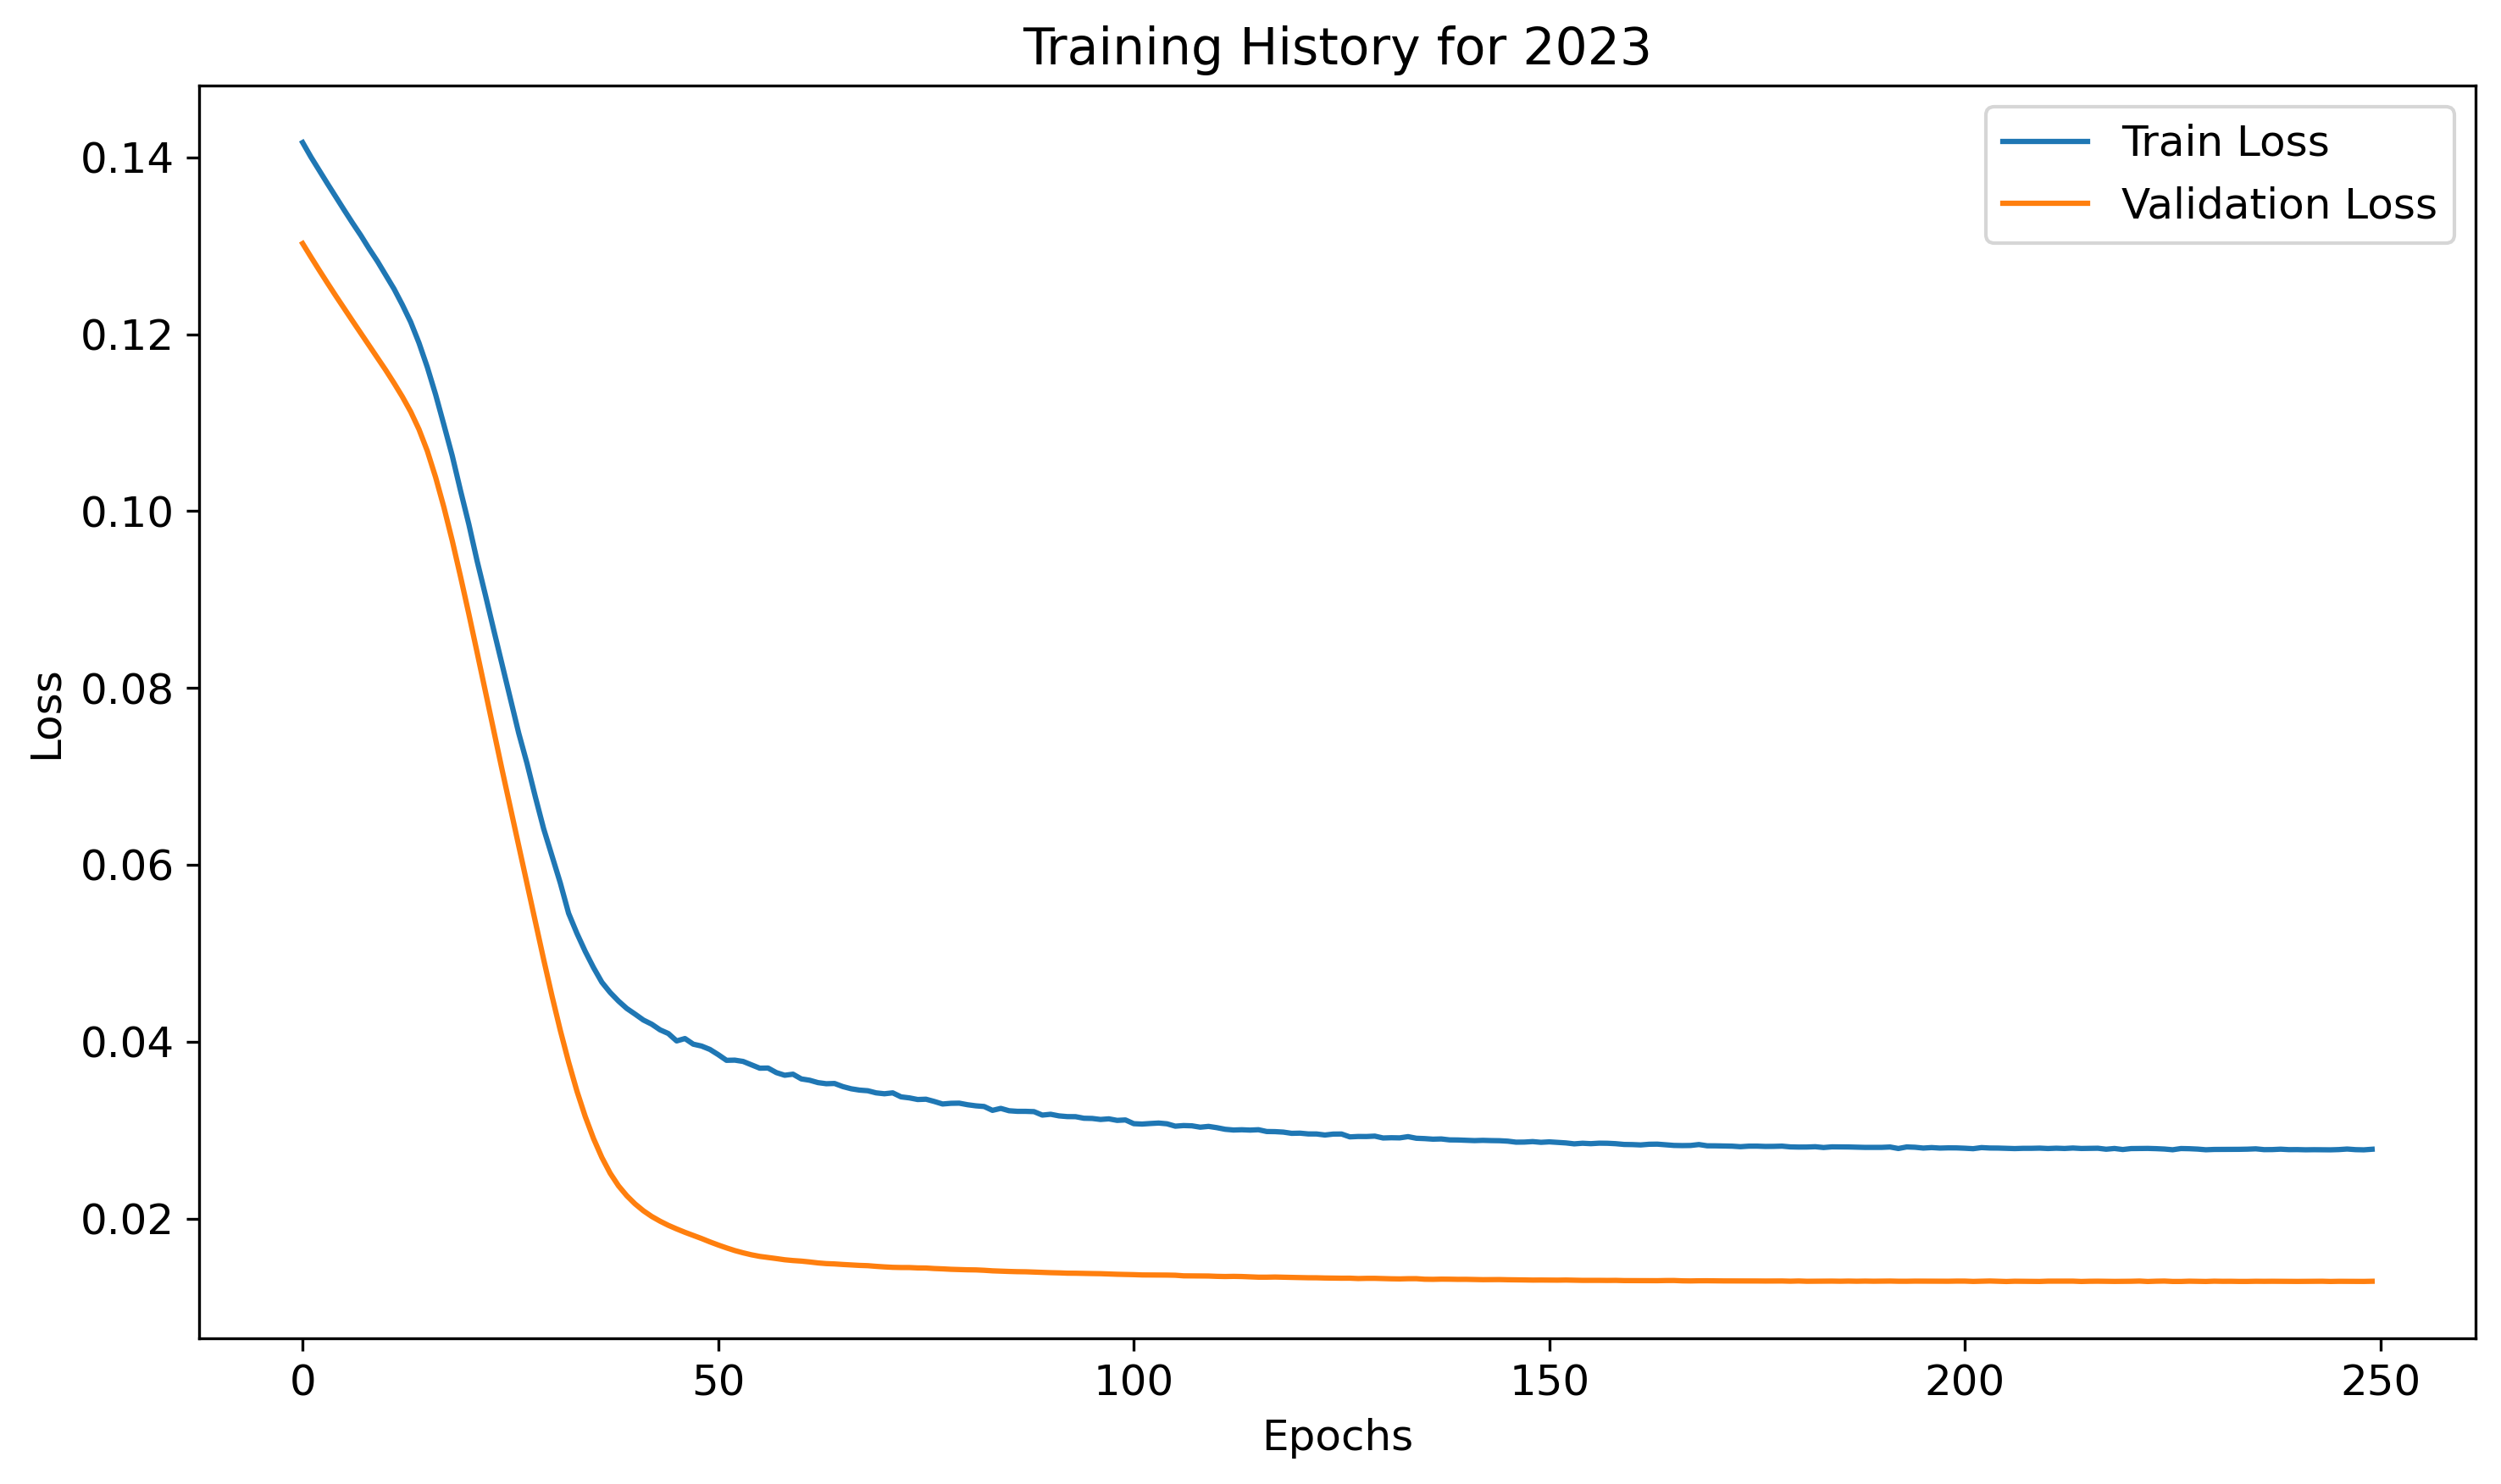

In [ ]:
# for y, period in periods.items():
#     # plot training history
#     plt.figure(figsize=(10, 6))
#     plt.plot(history[y]['train_loss'], label='Train Loss')
#     plt.plot(history[y]['val_loss'],   label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title(f'Training History for 2002-20{y}')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
#     plt.close()

# <a id='toc6_'></a>[Train linear models](#toc0_)

## <a id='toc6_1_'></a>[OLS](#toc0_)

In [ ]:
# linear model
# estimate the parameters
ols_est = {}
ols_pred_train = {}
ols_pred_test = {}

for y in periods.keys():
    print(f"Estimating OLS for {y}...")
    x_tr = X_train[y]
    y_tr = y_train[y]
    x_te = X_test[y]
    y_te = y_test[y]


    # estimate the parameters
    ols_est[y] = estimate(y_tr, x_tr)
    ols_pred_train[y] = ols_est[y]['b_hat'] @ x_tr.T
    ols_pred_test[y] = ols_est[y]['b_hat'] @ x_te.T

## <a id='toc6_2_'></a>[LASSO](#toc0_)

In [ ]:
# linear model
# create a grid using numpy.geomspace
penalty_grid = np.geomspace(1e-7, 100, num = 1000)

lasso_est = {}
lasso_pred_train = {}
lasso_pred_test = {}


with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    for y in periods.keys():
        print(f"Estimating Lasso for {y}...")
        x_tr = X_train[y]
        y_tr = y_train[y]
        x_te = X_test[y]
        y_te = y_test[y]

        # estimate the model using LassoCV
        fit_CV = LassoCV(cv=5, alphas=penalty_grid, max_iter=1000, eps=1e-3, n_jobs=-1).fit(x_tr,y_tr)
        lasso_pred_train[y] = fit_CV.predict(x_tr)
        lasso_pred_test[y] = fit_CV.predict(x_te)